In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn_evaluation import plot
import loadData
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree._tree import TREE_LEAF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation
import timeit

In [2]:
adult_training_set, adult_testing_set = loadData.loadDataWithTestSet('adult.data', 'adult.test')
adult_training_set.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country incomeCategory  
0          2174             0              40  United-States          <=50K  
1             0             0              13  United-States          <=50K  
2             0             0              40  United-States          <=50K  
3             0             0              40  United-States          <=50K  
4             0             0              40           Cuba          <=50K

In [3]:
# load data
adult_training_set, adult_testing_set = loadData.loadDataWithTestSet('adult.data', 'adult.test')
adult_training_set.head(2)
# preprocess data
# training set
adult_training_set_labels = adult_training_set.iloc[:,-1]
adult_training_set = adult_training_set.iloc[:,0:-1]
adult_training_set_labels[adult_training_set_labels.str.contains('>50K',na=False)] = 1
adult_training_set_labels[adult_training_set_labels.str.contains('<=50K',na=False)] = 0
adult_training_set_labels = adult_training_set_labels.astype('int')
# testing set
adult_testing_set_labels = adult_testing_set.iloc[:,-1]
adult_testing_set = adult_testing_set.iloc[:,0:-1]
adult_testing_set_labels[adult_testing_set_labels.str.contains('>50K',na=False)] = 1
adult_testing_set_labels[adult_testing_set_labels.str.contains('<=50K',na=False)] = 0
adult_testing_set_labels = adult_testing_set_labels.astype('int')

processed_adult_training_set = pd.get_dummies(adult_training_set, columns=['workclass','education','marital-status','occupation','relationship',
                                           'race','sex','native-country'])
processed_adult_testing_set = pd.get_dummies(adult_testing_set, columns=['workclass','education','marital-status','occupation','relationship',
                                           'race','sex','native-country'])
print(processed_adult_training_set.columns[~processed_adult_training_set.columns.isin(processed_adult_testing_set.columns)])
missing_column = np.zeros(16281)
missing_column = pd.DataFrame(missing_column, columns=['native-country_Holand-Netherlands'])
processed_adult_testing_set = pd.concat([processed_adult_testing_set,missing_column], axis=1)

metrics=[]

processed_adult_testing_set.head()

Index(['native-country_Holand-Netherlands'], dtype='object')


age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   25  226802              7             0             0              40   
1   38   89814              9             0             0              50   
2   28  336951             12             0             0              40   
3   44  160323             10          7688             0              40   
4   18  103497             10             0             0              30   

   workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0            0                      0                    0   
1            0                      0                    0   
2            0                      0                    1   
3            0                      0                    0   
4            1                      0                    0   

   workclass_Never-worked                ...                  \
0                       0                ...                   
1                       0                ...                   
2                       0                ...                   
3                       0                ...                   
4                       0                ...                   

   native-country_Puerto-Rico  native-country_Scotland  native-country_South  \
0                           0                        0                     0   
1                           0                        0                     0   
2                           0                        0                     0   
3                           0                        0                     0   
4                           0                        0                     0   

   native-country_Taiwan  native-country_Thailand  \
0                      0                        0   
1                      0                        0   
2                      0                        0   
3                      0                        0   
4                      0                        0   

   native-country_Trinadad&Tobago  native-country_United-States  \
0                               0                             1   
1                               0                             1   
2                               0                             1   
3                               0                             1   
4                               0                             1   

   native-country_Vietnam  native-country_Yugoslavia  \
0                       0                          0   
1                       0                          0   
2                       0                          0   
3                       0                          0   
4                       0                          0   

   native-country_Holand-Netherlands  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  

[5 rows x 108 columns]

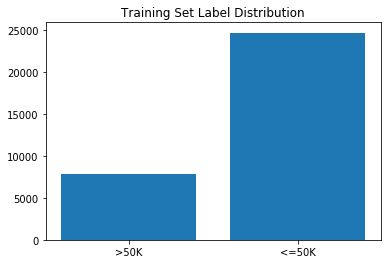

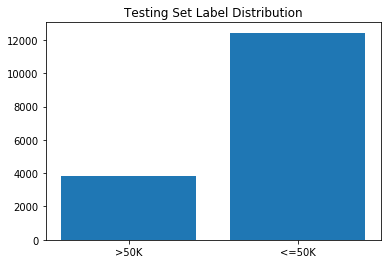

In [4]:
plt.bar(['>50K', '<=50K'],[len(adult_training_set_labels[adult_training_set_labels==1]), 
         len(adult_training_set_labels[adult_training_set_labels==0])])
plt.title('Training Set Label Distribution')
plt.savefig('training_set_label_dist.png')
plt.show()
plt.bar(['>50K', '<=50K'],[len(adult_testing_set_labels[adult_testing_set_labels==1]), 
         len(adult_testing_set_labels[adult_testing_set_labels==0])])
plt.title('Testing Set Label Distribution')
plt.savefig('testing_set_label_dist.png')
plt.show()

In [5]:
# decision tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(processed_adult_training_set, adult_training_set_labels)
print(dtc.tree_.node_count)
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

training_set_acc_DT = []
testing_set_acc_DT = []
thresholds = range(0, 500, 10)
for x in thresholds:
    prune_index(dtc.tree_, 0, x)
    predicted_training_set_labels = dtc.predict(processed_adult_training_set)
    predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
    training_set_acc_DT.append(accuracy_score(adult_training_set_labels, predicted_training_set_labels))
    
    predicted_testing_set_labels = dtc.predict(processed_adult_testing_set)
    predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
    testing_set_acc_DT.append(accuracy_score(adult_testing_set_labels, predicted_testing_set_labels))
print(training_set_acc_DT)
print(testing_set_acc_DT)


9357
[0.9999692884125181, 0.9103221645526858, 0.8926937133380425, 0.8848622585301434, 0.8809618869199349, 0.8781364208715948, 0.8746045883111698, 0.8728847394121803, 0.8718712570252757, 0.8692607720893093, 0.8689229446270078, 0.8681244433524768, 0.8671109609655723, 0.8667731335032708, 0.8656368047664383, 0.8652375541291729, 0.8649304382543533, 0.8649304382543533, 0.8635177052301833, 0.8633948588802555, 0.8633948588802555, 0.8633948588802555, 0.8627499155431344, 0.8627499155431344, 0.8624427996683148, 0.8620742606185313, 0.8613986056939283, 0.8613986056939283, 0.8613986056939283, 0.8613986056939283, 0.8600780074322042, 0.8600780074322042, 0.8600780074322042, 0.8600780074322042, 0.8596480452074567, 0.8596480452074567, 0.8596480452074567, 0.8596480452074567, 0.8591259482202636, 0.85875740917048, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.85848100488314

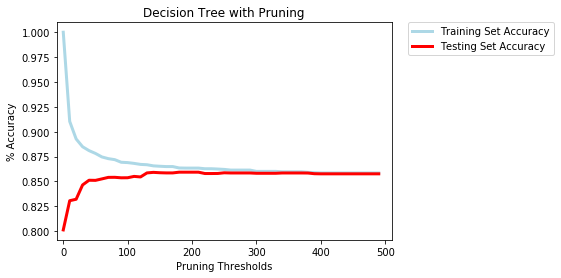

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(thresholds, training_set_acc_DT, color='lightblue', linewidth=3, label='Training Set Accuracy')
ax.plot(thresholds, testing_set_acc_DT, color='red', linewidth=3, label='Testing Set Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim(-10, 510)
ax.set(title='Decision Tree with Pruning',
 ylabel='% Accuracy', xlabel='Pruning Thresholds')
plt.savefig('DT1.png')
plt.show()

In [7]:
prune_index(dtc.tree_, 0, 350)
predicted_testing_set_labels = dtc.predict(processed_adult_testing_set)
target_names=['<=50K', '>50K']
print(classification_report(adult_testing_set_labels, predicted_testing_set_labels, target_names=target_names))
metrics.append(precision_recall_fscore_support(adult_testing_set_labels, predicted_testing_set_labels, average='weighted'))

             precision    recall  f1-score   support

      <=50K       0.88      0.94      0.91     12435
       >50K       0.75      0.60      0.67      3846

avg / total       0.85      0.86      0.85     16281



In [8]:
cv = cross_validation.ShuffleSplit(processed_adult_training_set.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
cv = 5
estimator = tree.DecisionTreeClassifier()
train_sizes = np.linspace(.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
        estimator, processed_adult_training_set, adult_training_set_labels, cv=cv, n_jobs=1, train_sizes=train_sizes)

plot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('dtcLearningCurve.png')
plt.clf()
plt.show()

<Figure size 432x288 with 0 Axes>

In [9]:
# graph decision tree as png
dot_data = tree.export_graphviz(dtc, out_file='tree1.dot', feature_names=processed_adult_training_set.columns, 
                                filled=True, rounded=True)  
graph = graphviz.Source(dot_data)
from subprocess import check_call
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

0

In [46]:
training_times=[]
testing_times=[]
start_time = timeit.default_timer()
estimator = tree.DecisionTreeClassifier()
estimator.fit(processed_adult_training_set,adult_training_set_labels)
end_time = timeit.default_timer()
elapsed = end_time - start_time
training_times.append(elapsed*1000)
print(elapsed*1000, 'milleseconds')
start_time = timeit.default_timer()
estimator.predict(processed_adult_testing_set)
end_time = timeit.default_timer()
elapsed = end_time - start_time
print(elapsed*1000, 'milleseconds')
testing_times.append(elapsed*1000)

396.9204018264918 milleseconds
12.060639269407147 milleseconds


In [10]:
# neural networks
nn = MLPClassifier(activation='logistic', solver='sgd')
nn.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = nn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = nn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.7591904425539756
0.7637737239727289


In [11]:
alphas = [0.0001, 0.0002, 0.0005, 0.0007, 0.001, 0.002, 0.005, 0.01]
learning_rates = [0.001, 0.002, 0.005, 0.007, 0.01]
momentums = [0.9, 0.85, 0.8, 0.75, 0.7]
param_grid = dict(alpha=alphas, learning_rate_init = learning_rates, momentum = momentums)
grid_nn = GridSearchCV(estimator=nn, param_grid=param_grid)
grid_result_nn = grid_nn.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_nn.best_score_, grid_result_nn.best_params_))
means = grid_result_nn.cv_results_['mean_test_score']
stds = grid_result_nn.cv_results_['std_test_score']
params = grid_result_nn.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_nn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc_nn=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_nn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc_nn=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc_nn)
print(testing_set_acc_nn)

Best: 0.762753 using {'alpha': 0.0007, 'learning_rate_init': 0.007, 'momentum': 0.7}
0.762753 (0.000460) with: {'alpha': 0.0007, 'learning_rate_init': 0.007, 'momentum': 0.7}
0.762538 (0.002066) with: {'alpha': 0.0005, 'learning_rate_init': 0.01, 'momentum': 0.8}
0.762231 (0.002344) with: {'alpha': 0.001, 'learning_rate_init': 0.01, 'momentum': 0.75}
0.762169 (0.003331) with: {'alpha': 0.0007, 'learning_rate_init': 0.01, 'momentum': 0.85}
0.761555 (0.001018) with: {'alpha': 0.0007, 'learning_rate_init': 0.005, 'momentum': 0.9}
0.761494 (0.001759) with: {'alpha': 0.01, 'learning_rate_init': 0.01, 'momentum': 0.8}
0.761371 (0.001576) with: {'alpha': 0.001, 'learning_rate_init': 0.005, 'momentum': 0.9}
0.761310 (0.001570) with: {'alpha': 0.005, 'learning_rate_init': 0.007, 'momentum': 0.75}
0.761279 (0.002922) with: {'alpha': 0.0005, 'learning_rate_init': 0.007, 'momentum': 0.8}
0.761279 (0.002465) with: {'alpha': 0.01, 'learning_rate_init': 0.007, 'momentum': 0.85}
0.761187 (0.001458) wi

0.7591904425539756
0.7637737239727289


In [12]:
print(classification_report(adult_testing_set_labels, predicted_testing_set_labels, target_names=target_names))
metrics.append(precision_recall_fscore_support(adult_testing_set_labels, predicted_testing_set_labels, average='weighted'))

             precision    recall  f1-score   support

      <=50K       0.76      1.00      0.87     12435
       >50K       0.00      0.00      0.00      3846

avg / total       0.58      0.76      0.66     16281



c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
cv = cross_validation.ShuffleSplit(processed_adult_training_set.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
cv = 5
estimator = MLPClassifier(activation='logistic', solver='sgd',alpha=0.0001, learning_rate_init=0.01, momentum=0.9)
train_sizes = np.linspace(.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
        estimator, processed_adult_training_set, adult_training_set_labels, cv=cv, n_jobs=1, train_sizes=train_sizes)

plot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('NNLearningCurve.png')
plt.clf()
plt.show()

<Figure size 432x288 with 0 Axes>

In [14]:
ax = plot.grid_search(grid_nn.grid_scores_, change=('alpha', 'learning_rate_init'),
              subset={'momentum': 0.7})
fig = ax.get_figure()
fig.set_size_inches(10, 8)
fig.savefig('NN1.png')
fig.clf()
ax = plot.grid_search(grid_nn.grid_scores_, change=('alpha', 'momentum'),
              subset={'learning_rate_init': 0.01})
fig = ax.get_figure()
fig.set_size_inches(10, 8)
fig.savefig('NN2.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 720x576 with 0 Axes>

In [47]:
start_time = timeit.default_timer()
estimator = MLPClassifier(activation='logistic', solver='sgd',alpha=0.0001, learning_rate_init=0.01, momentum=0.9)
estimator.fit(processed_adult_training_set,adult_training_set_labels)
end_time = timeit.default_timer()
elapsed = end_time - start_time
training_times.append(elapsed*1000)
print(elapsed*1000, 'milleseconds')
start_time = timeit.default_timer()
estimator.predict(processed_adult_testing_set)
end_time = timeit.default_timer()
elapsed = end_time - start_time
print(elapsed*1000, 'milleseconds')
testing_times.append(elapsed*1000)

1302.5908310502246 milleseconds
86.39736986305024 milleseconds


In [15]:
# boosting
gbc = GradientBoostingClassifier()
gbc.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = gbc.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = gbc.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.8690457909769356
0.8692954978195443


In [16]:
nEstimators = [100, 300, 500, 700, 900]
learning_rates = [0.1, 0.3, 0.5, 0.7, 1.0]
param_grid = dict(learning_rate = learning_rates, n_estimators = nEstimators)
grid_b = GridSearchCV(estimator=gbc, param_grid=param_grid)
grid_result_b = grid_b.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_b.best_score_, grid_result_b.best_params_))
means = grid_result_b.cv_results_['mean_test_score']
stds = grid_result_b.cv_results_['std_test_score']
params = grid_result_b.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_b.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_b.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.872271 using {'learning_rate': 0.1, 'n_estimators': 500}
0.872271 (0.002709) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.871533 (0.003613) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.871503 (0.002813) with: {'learning_rate': 0.1, 'n_estimators': 700}
0.870520 (0.003117) with: {'learning_rate': 0.1, 'n_estimators': 900}
0.869906 (0.003246) with: {'learning_rate': 0.3, 'n_estimators': 100}
0.869199 (0.002102) with: {'learning_rate': 0.3, 'n_estimators': 300}
0.869199 (0.002478) with: {'learning_rate': 0.5, 'n_estimators': 100}
0.867203 (0.004259) with: {'learning_rate': 0.7, 'n_estimators': 100}
0.865698 (0.003238) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.864593 (0.002049) with: {'learning_rate': 0.3, 'n_estimators': 500}
0.864562 (0.004306) with: {'learning_rate': 1.0, 'n_estimators': 100}
0.863333 (0.002371) with: {'learning_rate': 0.3, 'n_estimators': 700}
0.863333 (0.001091) with: {'learning_rate': 0.5, 'n_estimators': 300}
0.862228 (0.002393) with:

In [17]:
print(classification_report(adult_testing_set_labels, predicted_testing_set_labels, target_names=target_names))
metrics.append(precision_recall_fscore_support(adult_testing_set_labels, predicted_testing_set_labels, average='weighted'))

             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91     12435
       >50K       0.79      0.55      0.65      3846

avg / total       0.85      0.86      0.85     16281



In [18]:
ax = plot.grid_search(grid_b.grid_scores_, change=('learning_rate', 'n_estimators'))
fig = ax.get_figure()
fig.set_size_inches(10, 8)
fig.savefig('boosting1.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 720x576 with 0 Axes>

In [19]:
nEstimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
learning_rate=[0.1]
param_grid = dict(n_estimators = nEstimators, learning_rate=learning_rate)
grid_b2 = GridSearchCV(estimator=gbc, param_grid=param_grid)
grid_result_b2 = grid_b2.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_b2.best_score_, grid_result_b2.best_params_))
means = grid_result_b2.cv_results_['mean_test_score']
stds = grid_result_b2.cv_results_['std_test_score']
params = grid_result_b2.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_b2.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_b2.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.872209 using {'learning_rate': 0.1, 'n_estimators': 500}
0.872209 (0.002673) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.872117 (0.002955) with: {'learning_rate': 0.1, 'n_estimators': 400}
0.871994 (0.002440) with: {'learning_rate': 0.1, 'n_estimators': 600}
0.871595 (0.003610) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.871503 (0.002861) with: {'learning_rate': 0.1, 'n_estimators': 700}
0.870858 (0.003136) with: {'learning_rate': 0.1, 'n_estimators': 800}
0.870489 (0.003005) with: {'learning_rate': 0.1, 'n_estimators': 900}
0.869906 (0.002239) with: {'learning_rate': 0.1, 'n_estimators': 1000}
0.868800 (0.003531) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.865668 (0.003271) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.8866742421915789
0.8599594619495117


In [20]:
cv = cross_validation.ShuffleSplit(processed_adult_training_set.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
cv = 5
estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
train_sizes = np.linspace(.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
        estimator, processed_adult_training_set, adult_training_set_labels, cv=cv, n_jobs=1, train_sizes=train_sizes)
plot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('boostingLearningCurve.png')
plt.clf()
plt.show()

<Figure size 432x288 with 0 Axes>

In [48]:
start_time = timeit.default_timer()
estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
estimator.fit(processed_adult_training_set,adult_training_set_labels)
end_time = timeit.default_timer()
elapsed = end_time - start_time
training_times.append(elapsed*1000)
print(elapsed*1000, 'milleseconds')
start_time = timeit.default_timer()
estimator.predict(processed_adult_testing_set)
end_time = timeit.default_timer()
elapsed = end_time - start_time
print(elapsed*1000, 'milleseconds')
testing_times.append(elapsed*1000)

34840.503817351586 milleseconds
133.8792328766658 milleseconds


In [21]:
print(grid_b2.grid_scores_)
ax = plot.grid_search(grid_b2.grid_scores_, change='n_estimators')
fig = ax.get_figure()
fig.savefig('boosting2.png')
fig.set_size_inches(10, 8)
fig.clf()

[mean: 0.86567, std: 0.00327, params: {'learning_rate': 0.1, 'n_estimators': 100}, mean: 0.86880, std: 0.00353, params: {'learning_rate': 0.1, 'n_estimators': 200}, mean: 0.87159, std: 0.00361, params: {'learning_rate': 0.1, 'n_estimators': 300}, mean: 0.87212, std: 0.00295, params: {'learning_rate': 0.1, 'n_estimators': 400}, mean: 0.87221, std: 0.00267, params: {'learning_rate': 0.1, 'n_estimators': 500}, mean: 0.87199, std: 0.00244, params: {'learning_rate': 0.1, 'n_estimators': 600}, mean: 0.87150, std: 0.00286, params: {'learning_rate': 0.1, 'n_estimators': 700}, mean: 0.87086, std: 0.00314, params: {'learning_rate': 0.1, 'n_estimators': 800}, mean: 0.87049, std: 0.00301, params: {'learning_rate': 0.1, 'n_estimators': 900}, mean: 0.86991, std: 0.00224, params: {'learning_rate': 0.1, 'n_estimators': 1000}]


c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 720x576 with 0 Axes>

In [22]:
maxDepths = [3, 4, 5, 6, 7]
learning_rate=[0.1]
param_grid = dict(max_depth = maxDepths, learning_rate=learning_rate)
grid_b3 = GridSearchCV(estimator=gbc, param_grid=param_grid)
grid_result_b3 = grid_b3.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_b3.best_score_, grid_result_b3.best_params_))
means = grid_result_b3.cv_results_['mean_test_score']
stds = grid_result_b3.cv_results_['std_test_score']
params = grid_result_b3.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_b3.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_b3.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.871994 using {'learning_rate': 0.1, 'max_depth': 6}
0.871994 (0.002840) with: {'learning_rate': 0.1, 'max_depth': 6}
0.871411 (0.002571) with: {'learning_rate': 0.1, 'max_depth': 7}
0.871196 (0.003419) with: {'learning_rate': 0.1, 'max_depth': 5}
0.868708 (0.003091) with: {'learning_rate': 0.1, 'max_depth': 4}
0.865698 (0.003264) with: {'learning_rate': 0.1, 'max_depth': 3}
0.8916802309511379
0.8742092009090351


In [23]:
ax = plot.grid_search(grid_b3.grid_scores_, change=('max_depth'))
fig = ax.get_figure()
fig.savefig('boosting3.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

In [24]:
# KNN
knn = KNeighborsClassifier()
knn.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = knn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = knn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.8357851417339762
0.7769793010257355


In [25]:
n_neighbors = [5, 6, 7, 8, 9, 10]
weights = ["uniform", "distance"]
p = [1, 2, 3, 4]
param_grid = dict(n_neighbors = n_neighbors, weights = weights, p = p)
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid)
grid_result_knn = grid_knn.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means = grid_result_knn.cv_results_['mean_test_score']
stds = grid_result_knn.cv_results_['std_test_score']
params = grid_result_knn.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_knn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_knn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.797457 using {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.797457 (0.000361) with: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.796781 (0.001817) with: {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
0.795430 (0.000450) with: {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
0.795399 (0.000319) with: {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
0.794877 (0.000108) with: {'n_neighbors': 10, 'p': 3, 'weights': 'uniform'}
0.794785 (0.000407) with: {'n_neighbors': 10, 'p': 4, 'weights': 'uniform'}
0.794232 (0.000829) with: {'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
0.793342 (0.000792) with: {'n_neighbors': 8, 'p': 3, 'weights': 'uniform'}
0.792881 (0.000492) with: {'n_neighbors': 8, 'p': 4, 'weights': 'uniform'}
0.792543 (0.001005) with: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.792359 (0.001401) with: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
0.791591 (0.000193) with: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
0.791560 (0.000961) wi

In [26]:
target_names=['<=50K', '>50K']
print(classification_report(adult_testing_set_labels, predicted_testing_set_labels, target_names=target_names))
metrics.append(precision_recall_fscore_support(adult_testing_set_labels, predicted_testing_set_labels, average='weighted'))

             precision    recall  f1-score   support

      <=50K       0.81      0.97      0.88     12435
       >50K       0.74      0.24      0.36      3846

avg / total       0.79      0.80      0.76     16281



In [27]:
ax = plot.grid_search(grid_knn.grid_scores_, change=('n_neighbors', 'p'), subset={'weights': 'uniform'})
fig = ax.get_figure()
fig.set_size_inches(10, 8)
fig.savefig('knn1.png')
fig.clf()
ax = plot.grid_search(grid_knn.grid_scores_, change=('n_neighbors', 'p'), subset={'weights': 'distance'})
fig = ax.get_figure()
fig.set_size_inches(10, 8)
fig.savefig('knn2.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 720x576 with 0 Axes>

In [28]:
n_neighbors = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
weights = ["uniform"]
p = [1]
param_grid = dict(n_neighbors = n_neighbors, weights = weights, p=p)
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid)
grid_result_knn = grid_knn.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means = grid_result_knn.cv_results_['mean_test_score']
stds = grid_result_knn.cv_results_['std_test_score']
params = grid_result_knn.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_knn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_knn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.798808 using {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
0.798808 (0.000748) with: {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
0.798686 (0.002208) with: {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
0.798071 (0.000796) with: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
0.797457 (0.000361) with: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.796874 (0.000751) with: {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
0.796044 (0.001166) with: {'n_neighbors': 35, 'p': 1, 'weights': 'uniform'}
0.794693 (0.000799) with: {'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}
0.793710 (0.000792) with: {'n_neighbors': 45, 'p': 1, 'weights': 'uniform'}
0.791898 (0.001020) with: {'n_neighbors': 50, 'p': 1, 'weights': 'uniform'}
0.779307 (0.001875) with: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8050428426645373
0.8041275105951723


In [29]:
cv = cross_validation.ShuffleSplit(processed_adult_training_set.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
cv = 5
estimator = KNeighborsClassifier(n_neighbors= 25, p= 1, weights= 'uniform')
train_sizes = np.linspace(.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
        estimator, processed_adult_training_set, adult_training_set_labels, cv=cv, n_jobs=1, train_sizes=train_sizes)
plot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('knnLearningCurve.png')
plt.clf()
plt.show()

<Figure size 432x288 with 0 Axes>

In [30]:
print(classification_report(adult_testing_set_labels, predicted_testing_set_labels, target_names=target_names))

             precision    recall  f1-score   support

      <=50K       0.80      0.99      0.89     12435
       >50K       0.84      0.21      0.34      3846

avg / total       0.81      0.80      0.76     16281



In [31]:
ax = plot.grid_search(grid_knn.grid_scores_, change=('n_neighbors'))
fig = ax.get_figure()
fig.set_size_inches(10, 8)
fig.savefig('knn3.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 720x576 with 0 Axes>

In [49]:
start_time = timeit.default_timer()
estimator = KNeighborsClassifier(n_neighbors= 25, p= 1, weights= 'uniform')
estimator.fit(processed_adult_training_set,adult_training_set_labels)
end_time = timeit.default_timer()
elapsed = end_time - start_time
training_times.append(elapsed*1000)
print(elapsed*1000, 'milleseconds')
start_time = timeit.default_timer()
estimator.predict(processed_adult_testing_set)
end_time = timeit.default_timer()
elapsed = end_time - start_time
print(elapsed*1000, 'milleseconds')
testing_times.append(elapsed*1000)

496.96818264840203 milleseconds
1361.3866666666468 milleseconds


In [32]:
# SVM
svm_c = svm.SVC()
svm_c.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = svm_c.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = svm_c.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.9603206289733116
0.7604569743873226


In [33]:
# C_range = 10. ** np.arange(-3, 4)
# gamma_range = 10. ** np.arange(-3, 4)
# param_grid = dict(C = C_range, gamma = gamma_range)
# grid_svc = GridSearchCV(estimator=svm_c, param_grid=param_grid)
# grid_result_svc = grid_svc.fit(processed_adult_training_set, adult_training_set_labels)


# print("Best: %f using %s" % (grid_result_svc.best_score_, grid_result_svc.best_params_))
# means = grid_result_svc.cv_results_['mean_test_score']
# stds = grid_result_svc.cv_results_['std_test_score']
# params = grid_result_svc.cv_results_['params']
# results = zip(means, stds, params)
# for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    

# predicted_training_set_labels = grid_svc.predict(processed_adult_training_set)
# predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
# training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

# predicted_testing_set_labels = grid_svc.predict(processed_adult_testing_set)
# predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
# testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

# print(training_set_acc)
# print(testing_set_acc)

In [34]:
print(classification_report(adult_testing_set_labels, predicted_testing_set_labels, target_names=target_names))
metrics.append(precision_recall_fscore_support(adult_testing_set_labels, predicted_testing_set_labels, average='weighted'))

             precision    recall  f1-score   support

      <=50K       0.77      0.98      0.86     12435
       >50K       0.45      0.06      0.10      3846

avg / total       0.69      0.76      0.68     16281



In [35]:
cv = cross_validation.ShuffleSplit(processed_adult_training_set.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
cv = 5
estimator = svm.SVC()
train_sizes = np.linspace(.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
        estimator, processed_adult_training_set, adult_training_set_labels, cv=cv, n_jobs=1, train_sizes=train_sizes)
plot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('svmLearningCurve.png')
plt.clf()
plt.show()

<Figure size 432x288 with 0 Axes>

In [51]:
start_time = timeit.default_timer()
estimator = svm.SVC()
estimator.fit(processed_adult_training_set,adult_training_set_labels)
end_time = timeit.default_timer()
elapsed = end_time - start_time
training_times.append(elapsed*1000)
print(elapsed*1000, 'milleseconds')
start_time = timeit.default_timer()
estimator.predict(processed_adult_testing_set)
end_time = timeit.default_timer()
elapsed = end_time - start_time
print(elapsed*1000, 'milleseconds')
testing_times.append(elapsed*1000)

510924.5726392694 milleseconds
73128.76390867587 milleseconds


In [36]:
# ax = plot.grid_search(grid_svc.grid_scores_, change=('C', 'gamma'))
# fig = ax.get_figure()
# fig.set_size_inches(10, 8)
# fig.savefig('svm1.png')
# fig.clf()

In [37]:
print(metrics)
x=['Decision Tree', 'Neural Net', 'Boosting', 'KNN', 'SVM']
plt.bar(x, [prec[0] for prec in metrics])
plt.title('Precisions by Classifiers')
plt.ylim(0.0, 1.1)
plt.savefig('precisions.png')
plt.clf()

plt.bar(x, [rec[1] for rec in metrics])
plt.title('Recalls by Classifiers')
plt.ylim(0.0, 1.1)
plt.savefig('recalls.png')
plt.clf()

plt.bar(x, [f[2] for f in metrics])
plt.title('F1 Scores by Classifiers')
plt.ylim(0.0, 1.1)
plt.savefig('F1.png')
plt.clf()

[(0.8512548945356734, 0.8576254529820035, 0.8518444537461067, None), (0.5833503014311704, 0.7637737239727289, 0.6614797504945593, None), (0.854214798865117, 0.8600208832381303, 0.8506603469598725, None), (0.790830202565322, 0.8006264971439101, 0.7586860700906195, None), (0.6939371719731662, 0.7604569743873226, 0.6826275730520256, None)]


<Figure size 432x288 with 0 Axes>

In [52]:
print(training_times)
x=['Decision Tree', 'Neural Net', 'Boosting', 'KNN', 'SVM']
plt.bar(x, training_times)
plt.title('Training Times by Classifiers')
plt.ylabel('Milleseconds')
plt.savefig('training_times.png')
plt.clf()

print(training_times)
x=['Decision Tree', 'Neural Net', 'Boosting', 'KNN', 'SVM']
plt.bar(x, testing_times)
plt.title('Running Times by Classifiers')
plt.ylabel('Milleseconds')
plt.savefig('predicting_times.png')
plt.clf()

[396.9204018264918, 1302.5908310502246, 34840.503817351586, 496.96818264840203, 510924.5726392694]
[396.9204018264918, 1302.5908310502246, 34840.503817351586, 496.96818264840203, 510924.5726392694]


<Figure size 432x288 with 0 Axes>